<a href="https://colab.research.google.com/github/ProtoDD/pdd/blob/main/PDD_MNIST_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prototype Data Description
##Inter/Intra-class margin maximization


##Implementations
* AnoGAN-like Generator/Discriminator - unsupervised pretraining
* Leave-an-anomaly-class-out Training Data
* Within the discriminator feature space
* Inter/Intra-class margins computed by class-prototypes


# Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from urllib import request 
from itertools import combinations

In [2]:
from sklearn.manifold import TSNE
from sklearn.neighbors import KernelDensity, LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch import nn 
from torch import utils 
from torch.nn import init
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from sklearn.metrics import average_precision_score, precision_recall_curve

In [5]:
import os
from datetime import datetime, timedelta, timezone

In [6]:
from sklearn.metrics import precision_recall_curve

In [7]:
from sklearn.metrics import average_precision_score

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 68.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=287e3f407fe7fd1624d9d21d234b68303dc7cf16c5df4975b2ae1876b9f2d615
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=64e2ddaa4128770e1d6f6ee9c27ae8aa9c81fd8496023a06cd539345ce2b27d0
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [10]:
from umap import UMAP

In [11]:
model_umap = UMAP()

#Pretrained Models

In [12]:
import os

In [13]:
from urllib.request import urlretrieve

In [14]:
path_pretrained = './pretrained/'

In [15]:
if not os.path.exists(path_pretrained):
  os.mkdir(path_pretrained)

In [16]:
path_model_d = path_pretrained + 'discriminator.pkl'
path_model_g = path_pretrained + 'generator.pkl'

In [17]:
ood_classes = [1]
url_pretrained_g = 'https://tus.box.com/shared/static/qw15o5yhwb73zaqh9lh4ghqzp851w0vp.pkl'
url_pretrained_d = 'https://tus.box.com/shared/static/fp7xket1se3iuys9lgvvovkzo7fcxiy8.pkl'

In [18]:
urlretrieve(url_pretrained_d, path_model_d)
urlretrieve(url_pretrained_g, path_model_g)

('./pretrained/generator.pkl', <http.client.HTTPMessage at 0x7f1609195490>)

# Discriminator/Generator Class

In [19]:
# Generator receives random noise z and create 1x28x28 image

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [20]:
# Discriminator receives 1x28x28 image and returns a float number 0~1

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3,stride=2,padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        #('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        #nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
discriminator = nn.DataParallel(Discriminator(),device_ids=[0])
generator = nn.DataParallel(Generator(),device_ids=[0])

In [23]:
#load pretrained model
discriminator.load_state_dict(torch.load(path_model_d))
generator.load_state_dict(torch.load(path_model_g))

<All keys matched successfully>

# Log Path

In [24]:
import os
wdir = './wdir/'

logpath = wdir + 'log_'+str(ood_classes[0])+'/'

if os.path.exists(wdir):
  print(logpath+' exists')
else: 
  os.makedirs(logpath)
  print(logpath+' made')

./wdir/log_1/ made


#MNIST Dataset (from backup)

In [ ]:
from urllib import request
import codecs
from gzip import GzipFile

def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

def parse_byte(b):
    if isinstance(b, str):
        return ord(b)
    return b

def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        labels = [parse_byte(b) for b in data[8:]]
        assert len(labels) == length
        return torch.LongTensor(labels)

def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        idx = 16
        for l in range(length):
            img = []
            images.append(img)
            for r in range(num_rows):
                row = []
                img.append(row)
                for c in range(num_cols):
                    row.append(parse_byte(data[idx]))
                    idx += 1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1, 28, 28)

In [ ]:
#%%time
if False :
#try:
  mnist_train = MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5), (0.5)),
                        ]),
                        target_transform=None,
                        download=True)
else :
#except:
  print('Using box copy (30sec)')
  if not os.path.exists('/content/MNIST'):
    os.mkdir('/content/MNIST/')
    os.mkdir('/content/MNIST/raw')
    os.mkdir('/content/MNIST/processed')
  for box, gzfile in zip(['https://tus.box.com/shared/static/w48x3ihzku8di803sms8pprcubo933vk.gz', 
                        'https://tus.box.com/shared/static/4sk5phinu7b4litqzaun6rbh44drszvw.gz',
                        'https://tus.box.com/shared/static/4ixofoafdsucmodzda2wqofcbjesjcyt.gz',
                        'https://tus.box.com/shared/static/t11ksbgpf72zfhrwllqomaw1j3b1zgo3.gz'],
                       ['./MNIST/raw/train-images-idx3-ubyte.gz',
                        './MNIST/raw/train-labels-idx1-ubyte.gz',
                        './MNIST/raw/t10k-images-idx3-ubyte.gz',
                        './MNIST/raw/t10k-labels-idx1-ubyte.gz'
                        ]):
    request.urlretrieve(box,gzfile)
    with open(gzfile.replace('.gz', ''), 'wb') as out_f, GzipFile(gzfile) as zip_f: out_f.write(zip_f.read())

  training_set = (
    read_image_file('./MNIST/raw/train-images-idx3-ubyte'),
    read_label_file('./MNIST/raw/train-labels-idx1-ubyte')
    )
  test_set = (
    read_image_file('./MNIST/raw/t10k-images-idx3-ubyte'),
    read_label_file('./MNIST/raw/t10k-labels-idx1-ubyte')
    )
  
  with open('./MNIST/processed/training.pt', 'wb') as f: torch.save(training_set, f)
  with open('./MNIST/processed/test.pt', 'wb') as f: torch.save(test_set, f)

  mnist_train = MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5), (0.5)),
                        ]),
                        target_transform=None,
                        download=False)

Using box copy (30sec)


#MNIST Dataset (Train)

In [25]:
mnist_train = MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5), (0.5)),
                        ]),
                        target_transform=None,
                        download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Training Setup (Leave-one-class-out)

In [26]:
normal_classes = [ i for i in mnist_train.class_to_idx.values() if not (i in ood_classes) ]
normal_classes

[0, 2, 3, 4, 5, 6, 7, 8, 9]

In [27]:
# train_labels (non-anomaly classes)
position_normal_class = [i for i,j in enumerate(mnist_train.train_labels.tolist()) if not j in ood_classes]
np.array(position_normal_class)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


array([    0,     1,     2, ..., 59997, 59998, 59999])

In [28]:
mnist_data_normal = mnist_train.train_data[position_normal_class] 
mnist_label_normal = mnist_train.train_labels[position_normal_class] 

mnist_data_normal.shape, mnist_label_normal.shape

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


(torch.Size([53258, 28, 28]), torch.Size([53258]))

In [29]:
normal_dataset = TensorDataset(mnist_data_normal.view(len(mnist_data_normal),1,28,28).type_as(torch.FloatTensor()), mnist_label_normal)
normal_dataset.tensors[0].shape

torch.Size([53258, 1, 28, 28])

In [30]:
mnist_train.train_labels.set_(mnist_label_normal)
mnist_train.train_data.set_(mnist_data_normal)
mnist_train

Dataset MNIST
    Number of datapoints: 53258
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

# MNIST Dataset (Test)

In [31]:
mnist_test = MNIST("./", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5), (0.5)),
                        ]),
                        target_transform=None,
                        download=True)

# Prototype dataloader

In [32]:
sample_size = 10

In [33]:
# generator seed
import time
#seed = 1234
seed = int(time.time())
print(seed)
np.random.seed(seed)

1661918901


In [34]:
exemplar_ids = [np.random.choice(np.where(np.array(mnist_train.targets) == i)[0],size=sample_size,replace=False) 
for i in np.unique(mnist_train.targets) ]

exemplar_labels = mnist_train.targets.numpy()[np.array(exemplar_ids)]

In [35]:
prototype_ids = np.concatenate(exemplar_ids)
prototype_labels = np.array(mnist_train.targets)[prototype_ids]

In [36]:
len(exemplar_ids), len(prototype_ids)

(9, 90)

In [37]:
mnist_proto = MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5), (0.5)),
                        ]),
                        target_transform=None,
                        download=True)

mnist_data_proto = mnist_train.data[prototype_ids] 
mnist_label_proto = mnist_train.targets[prototype_ids]

mnist_proto.data = mnist_data_proto
mnist_proto.targets = mnist_label_proto

prototype_loader = torch.utils.data.DataLoader(
    dataset=mnist_proto,
    batch_size=10,
    shuffle=False,
    drop_last=False)

prototype_reshape = np.arange(len(prototype_labels)).reshape(exemplar_labels.shape)

mnist_label_proto

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

#Pre-trained feature extraction

In [38]:
test_loader = torch.utils.data.DataLoader(
    dataset=mnist_test,
    batch_size=50,
    shuffle=False,
    drop_last=False)

In [39]:
dout_real_test =[]
testlabels = [] 
start = time.time()

#for j,(image,label) in zip(range(100),test_loader):
for j,(image,label) in enumerate(test_loader):

  dout_real_test.append(discriminator(image)[1].cpu())
  testlabels.extend(label.tolist())

  if j % 200 == 0 : 
    print(j,' ETA: ',(len(test_loader)-j-1)*(time.time()-start)/(j+1)/60)

deepfeat_real_test = torch.cat(dout_real_test).detach().numpy()
print(deepfeat_real_test.shape)

0  ETA:  26.868739954630534
(10000, 3136)


In [40]:
%%time
dout_real_train =[]
trainlabels = [] 
start = time.time()

train_loader = torch.utils.data.DataLoader(
    dataset=mnist_train,
    batch_size=200,
    shuffle=False,
    drop_last=False)

for j,(image,label) in enumerate(train_loader):
  dout_real_train.append(discriminator(image)[1].cpu())
  trainlabels.extend(label.tolist())

deepfeat_real_train = torch.cat(dout_real_train).cpu().detach().numpy()
deepfeat_real_train.shape

CPU times: user 8.62 s, sys: 733 ms, total: 9.35 s
Wall time: 9.02 s


(53258, 3136)

In [41]:
dout_prototypes =[]
label_prototypes = [] 

for j,(image,label) in enumerate(prototype_loader):

  dout_prototypes.append(discriminator(image)[1])
  label_prototypes.extend(label.tolist())

dout_prototype_tensor = torch.cat(dout_prototypes)
label_prototype_tensor = torch.LongTensor(label_prototypes)

dout_prototype_tensor.size(), label_prototype_tensor.size()

(torch.Size([90, 3136]), torch.Size([90]))

# Visualization - UMAP

In [51]:
dout_train_sample, _, trainlabels_sample, _ = train_test_split(deepfeat_real_train, trainlabels, train_size=5000, shuffle = False)
dout_test_sample, _, testlabels_sample, _ = train_test_split(deepfeat_real_test, testlabels, train_size=5000, shuffle = False)
dout_train_sample.shape, dout_test_sample.shape

((5000, 3136), (5000, 3136))

In [52]:
umap2 = UMAP()
umap2

UMAP()

In [53]:
dout_combined_sample = np.concatenate([dout_train_sample, 
                                       dout_test_sample[np.where(np.array(testlabels_sample)==ood_classes[0])[0]],
                                       dout_prototype_tensor.detach().cpu().numpy()])
dout_combined_sample.shape

(5661, 3136)

In [54]:
#May take up to 30 secs
%%time
umap2.fit(dout_combined_sample)

CPU times: user 47.6 s, sys: 1.46 s, total: 49.1 s
Wall time: 8.76 s


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [55]:
X_umap2_train_sample = umap2.transform(dout_train_sample)

In [56]:
%%time
X_umap2_ood_sample = umap2.transform(dout_test_sample[np.where(np.array(testlabels_sample)==ood_classes[0])[0]])

CPU times: user 3.3 s, sys: 46.4 ms, total: 3.35 s
Wall time: 2.69 s


In [57]:
%%time
X_umap2_prototypes = umap2.transform(dout_prototype_tensor.detach().cpu().numpy())

CPU times: user 2.95 s, sys: 11.9 ms, total: 2.96 s
Wall time: 2.68 s


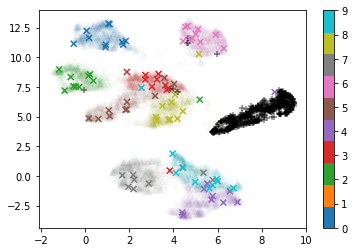

In [59]:
plt.scatter(X_umap2_train_sample[:,0], X_umap2_train_sample[:,1], 
            c=trainlabels_sample, cmap='tab10',alpha=0.02, marker='^')
plt.scatter(X_umap2_ood_sample[:,0], X_umap2_ood_sample[:,1], 
            color='black', alpha=0.5, marker='+')
plt.scatter(X_umap2_prototypes[:,0], X_umap2_prototypes[:,1], 
            c=label_prototype_tensor, cmap='tab10', alpha=0.99, marker='x')
plt.colorbar()
plt.show()

#Training parameters

In [68]:
def image_check(gen_fake):
    img = gen_fake.data.numpy()
    fig, axes = plt.subplots(2,8,figsize=(15,3)) 
    for axis,im in zip(axes.ravel(),img):
        axis.imshow(im[0],cmap='gray')
    plt.show()

In [67]:
n_epochs = 40
r_block_in = 2 
gacc = 2
batch_size = 100
learning_rate = 0.0002
num_gpus = 1

In [69]:
#loss_func = nn.MSELoss()
loss_func = nn.BCELoss()

train_loader = DataLoader(dataset=mnist_train,
                          batch_size=batch_size,shuffle=True,drop_last=True)

#PDD Training

In [ ]:
# loss function, optimizers, and labels for training
generator.train()
discriminator.train()

gen_optim = torch.optim.Adam(generator.parameters(), lr= gacc*learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

optim_intra = torch.optim.Adam(discriminator.parameters(), lr=0.01*learning_rate, betas=(0.5,0.999))
optim_inter = torch.optim.Adam(discriminator.parameters(), lr=0.001*learning_rate, betas=(0.5,0.999))


ones_label = Variable(torch.ones(batch_size,1)).cuda()
zeros_label = Variable(torch.zeros(batch_size,1)).cuda()

In [ ]:

dis_loss_list = []
gen_loss_list = []

loss_reg_list = []
loss_std_list = []
loss_mean_list = []

In [ ]:
start = time.time()
for total_epoch, i in enumerate(range(n_epochs), nepochs_pretrained):
    for j,(image,label) in enumerate(train_loader):
        image = Variable(image).cuda()
        
        # generator
        gen_optim.zero_grad()
        
        z = Variable(init.normal_(torch.Tensor(gacc*batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,torch.ones_like(dis_fake))) # fake classified as real
        gen_loss.backward(retain_graph=True)
        gen_optim.step()
    
        # discriminator
        dis_optim.zero_grad()
        
        z = Variable(init.normal_(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        dis_real,_ = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,torch.zeros_like(dis_fake))) + torch.sum(loss_func(dis_real,torch.ones_like(dis_real)))
        dis_loss.backward()
        dis_optim.step()

        # クラス間距離
        if True: #i == 0 : # 
                  #optimizer.zero_grad()
                  optim_intra.zero_grad()

                  # 典型例の射影更新
                  dout_prototypes =[]
                  label_prototypes = [] 
                  for j,(image,label) in enumerate(prototype_loader):
                    dout_prototypes.append(discriminator(image)[1])
                    label_prototypes.append(label)

                  dout_prototype_tensor = torch.cat(dout_prototypes)
                  label_prototype_tensor = torch.cat(label_prototypes)
                  size_expand = torch.Size([len(dout_prototype_tensor)])+dout_prototype_tensor.size()

                  # 距離行列（全典型例の間）
                  cdist_prototypes = torch.sum((
                    dout_prototype_tensor.unsqueeze(dim=0).expand(size_expand) - \
                    dout_prototype_tensor.unsqueeze(dim=1).expand(size_expand)
                    )**2, dim=2)
                
                  # クラス内距離の行列だけ取り出す
                  intra_cdist_mat = [cdist_prototypes[torch.where(label_prototype_tensor==i)[0]][:,torch.where(label_prototype_tensor==i)[0]]
                                   for i in np.unique(label_prototype_tensor)
                                   ]

                  #対角成分以外を取り出して偏差と平均
                  intra_cdist_std_mean = torch.stack([torch.stack(torch.std_mean(torch.masked_select(matrix, matrix != torch.triu(matrix))))
                  for matrix in intra_cdist_mat])

                  # クラス内距離の中央値
                  intra_R_min = torch.median(intra_cdist_std_mean[:,1])
                  #intra_R_min.detach() # detach - 定数
                  
                  #クラス内距離損失 (最小値からの標準偏差)
                  if i % r_block_in == 0:#block割合
                    loss_intra = torch.sqrt(torch.mean(torch.masked_select((intra_cdist_std_mean[:,1] - intra_R_min)**2, intra_cdist_std_mean[:,1] > intra_R_min)))
                    loss_intra.backward()
                    optim_intra.step()
                    loss_std_list.append(loss_intra.tolist())

                  optim_inter.zero_grad()
                  #クラス内距離の最大値+2偏差
                  intra_R_max = torch.amax(intra_cdist_std_mean[:,1] + 2*intra_cdist_std_mean[:,0] )
                  intra_R_max.detach() # detach - 定数

                  # 距離行列（全典型例の間）
                  cdist_prototypes2 = torch.sum((
                    dout_prototype_tensor.unsqueeze(dim=0).expand(size_expand) - \
                    dout_prototype_tensor.unsqueeze(dim=1).expand(size_expand)
                    )**2, dim=2)
                  # クラス間距離の行列だけ取り出す
                  inter_cdist_mat = [cdist_prototypes2[torch.where(label_prototype_tensor==i)[0]][:,torch.where(label_prototype_tensor==j)[0]]
                                   for i,j in combinations(np.unique(label_prototype_tensor), 2)
                                   ]

                  # 結合
                  inter_cdist_triu = torch.cat([torch.masked_select(matrix, matrix != torch.triu(matrix)) for matrix in inter_cdist_mat])
                  # クラス間距離の基準 (クラス間距離の中央値とクラス内距離の2偏差の大きい方)
                  inter_R = max(inter_cdist_triu.median(), intra_R_max).detach()

                  #クラス間距離の損失 (基準より小さい距離の平均)
                  #loss_inter = torch.log(torch.mean(torch.masked_select((inter_R - inter_cdist_triu)**2, inter_cdist_triu<inter_R)))

                  if i % r_block_in != 0:#block割合
                    loss_inter = torch.sqrt(torch.mean(torch.masked_select((inter_R - inter_cdist_triu)**2, inter_cdist_triu<inter_R)))
                    loss_inter.backward()
                    optim_inter.step()
                    loss_mean_list.append(loss_inter.tolist())

                  #クラス内・クラス間・合計損失のログ
                  if i > 1:
                    loss = loss_intra+loss_inter
                    loss_reg_list.append(loss.tolist())
                  #loss.backward()
                  #optimizer.step()


        gen_loss_list.append(gen_loss.tolist())
        dis_loss_list.append(dis_loss.tolist())
    
    # save model every epochs
    if (i % 1 == 0):
      image_check(gen_fake.cpu())
      print('Epoch: ', total_epoch, ' ETA: ', (n_epochs - i -1)*(time.time()-start)/(i+1)/60, 'MPE: ', (time.time()-start)/(i+1)/60)
      if i != 0:
              fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,3))
              axes[0].plot(gen_loss_list,linestyle='None',marker='x',alpha=0.1,color='blue')
              axes[0].set_title('gen')
              axes[1].plot(dis_loss_list,linestyle='None',marker='.',alpha=0.1,color='orange')
              axes[1].set_title('dis')
              plt.show()
              
              model_path_g = logpath+'generator_'+str(total_epoch)+'_'+str(ood_classes[0])+'.pkl'
              model_path_d = logpath+'discriminator_'+str(total_epoch)+'_'+str(ood_classes[0])+'.pkl'
              torch.save(generator.state_dict(), model_path_g)
              torch.save(discriminator.state_dict(), model_path_d)
              print(model_path_g, model_path_d)

              fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,3))
              axes[0].plot(np.array(loss_mean_list[:]),linestyle='None',marker='.',color='green')
              axes[0].set_title('inter')
              axes[1].plot(np.array(loss_std_list[:]),linestyle='None',marker='+',color='magenta')
              axes[1].set_title('intra')

# Learning Curves

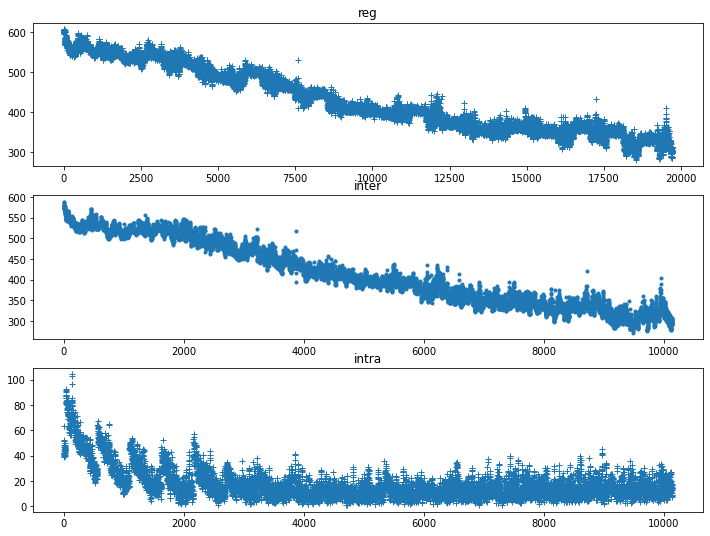

In [ ]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(12,9))
axes[0].plot(np.array(loss_reg_list[500:]),linestyle='None',marker='+')
axes[0].set_title('reg')

axes[1].plot(np.array(loss_mean_list[500:]),linestyle='None',marker='.')
axes[1].set_title('inter')

axes[2].plot(np.array(loss_std_list[500:]),linestyle='None',marker='+')
axes[2].set_title('intra')

#axes[1][1].plot(np.array(loss_quartile_list))
#axes[1][1].set_title('quart')
plt.show()

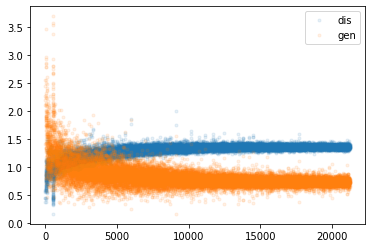

In [ ]:
plt.plot(dis_loss_list[50:],marker='.',linestyle='None', alpha=0.1)
plt.plot(gen_loss_list[50:],marker='.',linestyle='None', alpha = 0.1)
plt.legend(['dis','gen'])
plt.show()

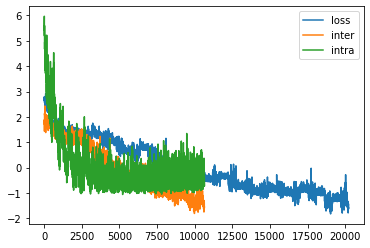

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

plt.plot(scaler.fit_transform(np.array(loss_reg_list).reshape(-1,1)))
plt.plot(scaler.fit_transform(np.array(loss_mean_list).reshape(-1,1)))
plt.plot(scaler.fit_transform(np.array(loss_std_list).reshape(-1,1)))
#plt.plot(scaler.fit_transform(np.array(loss_quartile_list).reshape(-1,1)))
plt.legend(['loss','inter','intra'])
plt.show()

#Post-training Feature Extraction

In [ ]:
discriminator.eval()

DataParallel(
  (module): Discriminator(
    (layer1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (layer2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (fc): Sequential(
      (0): Linear(in_features=3136, o

In [ ]:
test_loader = torch.utils.data.DataLoader(
    dataset=mnist_test,
    batch_size=100,
    shuffle=False,
    drop_last=False)

In [ ]:
%%time
dafter_test =[]
labels_test = [] 
start = time.time()

#for j,(image,label) in zip(range(40),test_loader):
for j,(image,label) in enumerate(test_loader):

  dafter_test.append(discriminator(image)[1])
  labels_test.extend(label.tolist())

dafter_test_array = torch.cat(dafter_test).cpu().detach().numpy()
labels_test_array = np.array(labels_test)

dafter_test_array.shape, labels_test_array.shape

CPU times: user 1.2 s, sys: 35.2 ms, total: 1.23 s
Wall time: 1.23 s


In [ ]:
%%time
dafter_train =[]
labels_train = [] 
start = time.time()

for j,(image,label) in zip(range(10),train_loader):#バッチ数を指定してサンプリング
  #for j,(image,label) in enumerate(train_loader):

    dafter_train.append(discriminator(image)[1])
    labels_train.extend(label.tolist())

dafter_train_array = torch.cat(dafter_train).cpu().detach().numpy()
labels_train_array = np.array(labels_train)
dafter_train_array.shape, labels_train_array.shape

CPU times: user 134 ms, sys: 10 ms, total: 144 ms
Wall time: 129 ms


In [ ]:
dafter_prototypes =[]
label_prototypes = [] 

for j,(image,label) in enumerate(prototype_loader):
  dafter_prototypes.append(discriminator(image)[1])
  label_prototypes.append(label)

dafter_prototype_tensor = torch.cat(dafter_prototypes).detach().cpu()
label_prototype_tensor = torch.cat(label_prototypes)

label_prototype_tensor.size()

torch.Size([90])

# Visualization - UMAP

In [ ]:
dafter_train_array.shape, \
dafter_test_array.shape, \
dafter_prototype_tensor.numpy().shape

((1000, 3136), (10000, 3136), (90, 3136))

In [ ]:
umap2 = UMAP()
umap2

UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1,
     n_neighbors=15, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)

In [ ]:
dafter_combined_array = np.concatenate([#dafter_train_array, 
                                       dafter_test_array,
                                       dafter_prototype_tensor.numpy()])
dafter_combined_array.shape

(10090, 3136)

In [ ]:
#5000.3136 26s #1000.3136 8s #500.3136 5s #200.3136 3s
%%time
umap2.fit(dafter_combined_array)

CPU times: user 26 s, sys: 761 ms, total: 26.8 s
Wall time: 9.69 s


UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1,
     n_neighbors=15, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)

In [ ]:
%%time
X_umap2_train = umap2.transform(dafter_train_array)

CPU times: user 6.55 s, sys: 255 ms, total: 6.81 s
Wall time: 5.62 s


In [ ]:
%%time
X_umap2_test = umap2.transform(dafter_test_array)

CPU times: user 18 s, sys: 941 ms, total: 18.9 s
Wall time: 13.8 s


In [ ]:
%%time
X_umap2_prototypes = umap2.transform(dout_prototype_tensor.detach().cpu().numpy())

CPU times: user 2.52 s, sys: 19.2 ms, total: 2.54 s
Wall time: 2.48 s


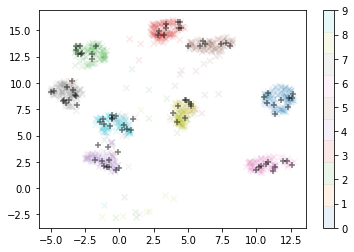

In [ ]:
plt.scatter(X_umap2_train[:,0], X_umap2_train[:,1], 
            c=labels_train_array, cmap='tab10', alpha=0.1, marker='x')
plt.colorbar()
plt.scatter(X_umap2_prototypes[:,0], X_umap2_prototypes[:,1], 
            color='black',alpha=0.5, marker='+')
plt.show()

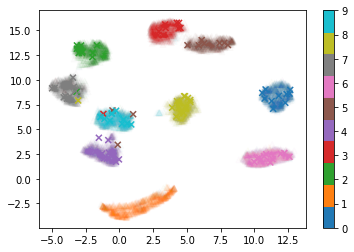

In [ ]:
plt.scatter(X_umap2_test[:,0], X_umap2_test[:,1], 
            c=labels_test_array, cmap='tab10',alpha=0.02, marker='^')
plt.scatter(X_umap2_prototypes[:,0], X_umap2_prototypes[:,1], 
            c=label_prototype_tensor, cmap='tab10', alpha=0.99, marker='x')
plt.colorbar()
plt.show()

# Prototype KDE

In [ ]:
bw = 10

In [ ]:
scaler = MinMaxScaler()

In [ ]:
umap3 = UMAP(n_components=3)

In [ ]:
dafter_combined_test = np.concatenate([dafter_test_array, 
                                            dafter_prototype_tensor.detach().cpu().numpy()])
dafter_combined_test.shape

(10090, 3136)

In [ ]:
%%time
X_umap3_combined_test = umap3.fit(dafter_combined_test)

CPU times: user 26.7 s, sys: 782 ms, total: 27.4 s
Wall time: 9.85 s


In [ ]:
%%time
X_umap3_test_after = umap3.transform(dafter_test_array)
X_umap3_prototypes_after = umap3.transform(dafter_prototype_tensor.detach().cpu().numpy())

CPU times: user 24.8 s, sys: 1.26 s, total: 26 s
Wall time: 19.6 s


In [ ]:
model_kde = KernelDensity(bandwidth=bw)

In [ ]:
model_kde_prototypes = [ KernelDensity(bandwidth=bw).fit(X_umap3_prototypes_after[np.where(np.array(label_prototype_tensor)==i)]) 
for i in np.unique(label_prototype_tensor) ] 
len(model_kde_prototypes)

9

In [ ]:
score_kde_prototypes = [ model.score_samples(X_umap3_test_after) for model in model_kde_prototypes]

In [ ]:
scaled_score_prototypes = [ (score - np.max(score))/(np.max(score)-np.quantile(score, 0.9)) 
for score in score_kde_prototypes]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


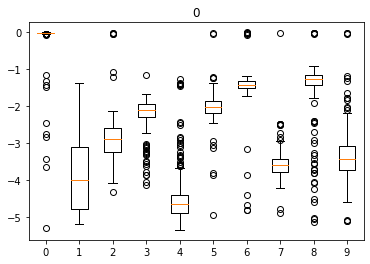

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


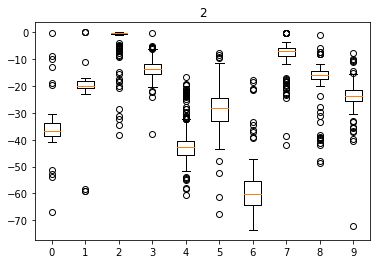

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


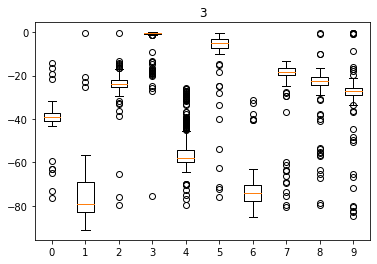

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


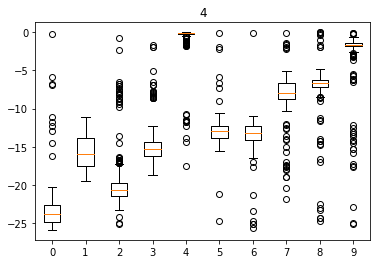

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


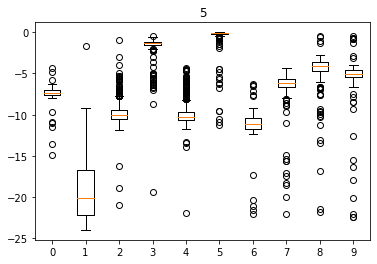

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


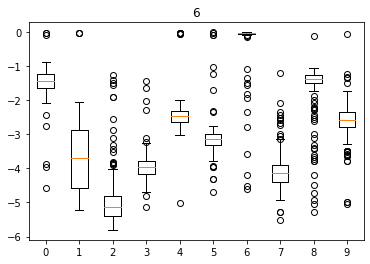

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


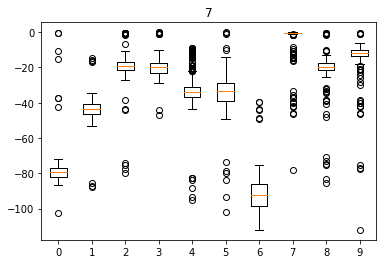

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


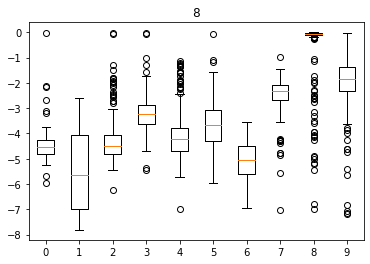

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


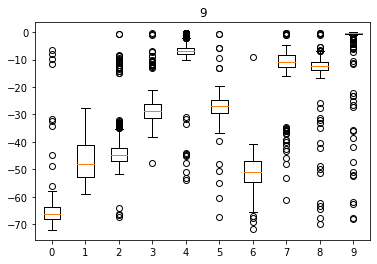

In [ ]:
for j, score in zip(np.unique(label_prototype_tensor), scaled_score_prototypes):

  data_boxplot = [(score)[np.where(labels_test_array==i)] for i in np.unique(labels_test_array)]

  fig, axes = plt.subplots()

  axes.boxplot(data_boxplot, labels=np.unique(labels_test_array))

  axes.set_title(str(j))

  plt.show()

In [ ]:
score_agg = np.max(scaled_score_prototypes, axis=0) #+kde_scores_prototypes[-1]
score_agg.shape

(10000,)

## Boxplot & AUC evaluations

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


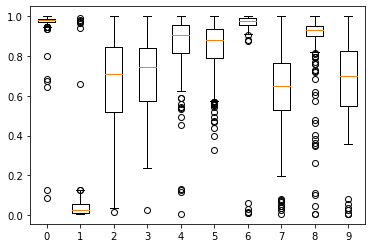

In [ ]:
data = [np.exp(score_agg)[np.where(np.array(labels_test_array)==i)] for i in np.unique(labels_test_array)]

fig, axes = plt.subplots()

axes.boxplot(data, labels=np.unique(labels_test_array))

plt.show()

In [ ]:
y_roc = labels_test_array == ood_classes[0]
roc_auc_score(y_roc, -score_agg)

0.9936944525195603

roc: 0.9936944525195603


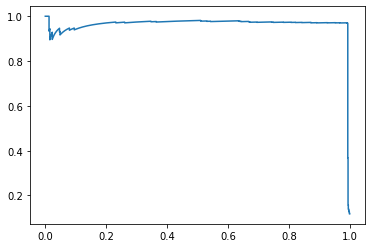

prc:  0.9648673138122262


In [ ]:
y_roc = [i in ood_classes for i in labels_test_array]
print('roc:', roc_auc_score(y_roc, -score_agg)) 

pr, re, th = precision_recall_curve(y_roc,-score_agg)
plt.plot(re, pr)
plt.show()
print('prc: ', average_precision_score(y_roc, -score_agg))